In [105]:
import torch
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()

In [106]:
chars = sorted(list(set(''.join(words))))

In [107]:
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [108]:
# build dataset

block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [109]:
# split into splits

import random
random.seed(21476891001)
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

tensor(-0.0071) tensor(0.9991)
tensor(0.0051) tensor(0.9979)


(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 7.000e+00,
        4.000e+00, 8.000e+00, 9.000e+00, 1.100e+01, 1.700e+01, 2.700e+01,
        3.000e+01, 3.800e+01, 5.000e+01, 4.200e+01, 5.400e+01, 9.700e+01,
        1.120e+02, 1.070e+02, 1.480e+02, 1.660e+02, 1.970e+02, 2.690e+02,
        3.340e+02, 3.670e+02, 4.570e+02, 5.210e+02, 6.290e+02, 8.210e+02,
        9.690e+02, 1.158e+03, 1.349e+03, 1.664e+03, 1.905e+03, 2.258e+03,
        2.535e+03, 2.977e+03, 3.332e+03, 3.938e+03, 4.269e+03, 4.845e+03,
        5.402e+03, 6.035e+03, 6.346e+03, 6.893e+03, 7.462e+03, 7.861e+03,
        8.048e+03, 8.374e+03, 8.620e+03, 8.488e+03, 8.381e+03, 8.173e+03,
        7.748e+03, 7.303e+03, 6.907e+03, 6.325e+03, 5.804e+03, 5.315e+03,
        4.772e+03, 4.179e+03, 3.829e+03, 3.301e+03, 2.849e+03, 2.495e+03,
        2.182e+03, 1.893e+03, 1.578e+0

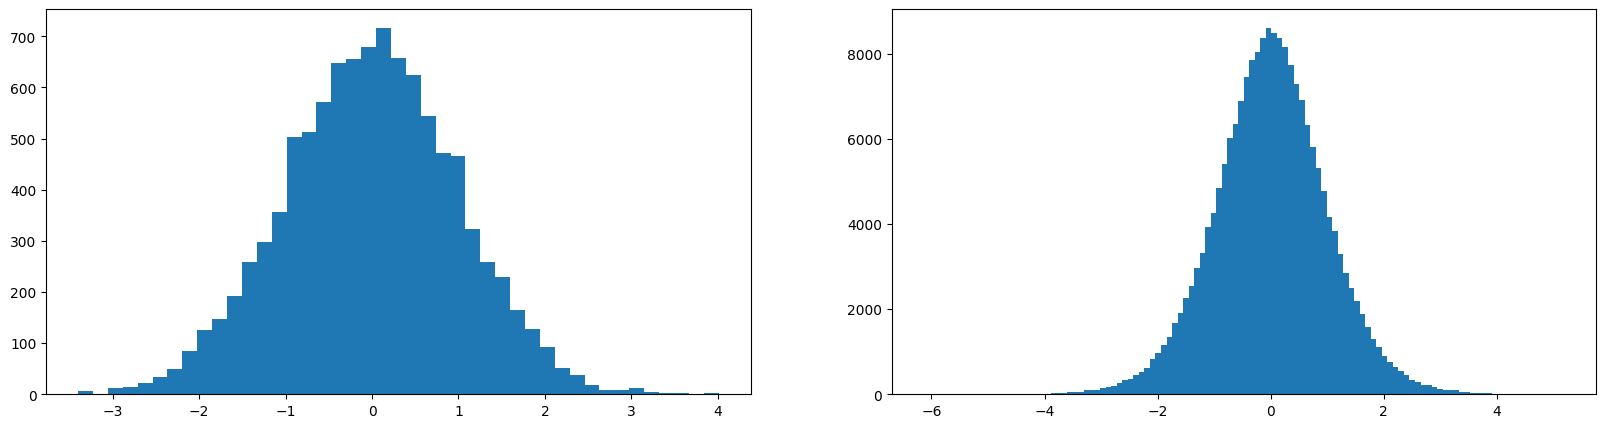

In [110]:
x = torch.randn(1000, 10) # 10 is called the fan in
w = torch.randn(10, 200) / 10 ** 0.5 # helps vanishing or exploding the gradient
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), int(2*(len(x.view(-1).tolist()) ** (1. / 3))))
plt.subplot(122)
plt.hist(y.view(-1).tolist(), int(2*(len(y.view(-1).tolist()) ** (1. / 3))))

In [111]:
(torch.randn(10000)).std() * 0.2

tensor(0.2009)

In [112]:
(5/3) / (30 ** 0.5)

0.3042903097250923

In [116]:
# MLP impl
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # dimensionality of neurons in the hidden layer

g = torch.Generator().manual_seed(21476891001)
C = torch.randn((vocab_size, n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (30 ** 0.5) # calculate gain / (n_embd * blocksize ** 0.5) normalize W for preactivation
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden)) 

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [117]:
# initial loss = 32
expected_loss = -torch.tensor(1 / 27).log()

# 4-dim example of issue
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss



(tensor([8.1729e-02, 6.9581e-07, 1.4416e-05, 9.1826e-01]), tensor(11.1472))

In [118]:
# optimization / training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # train with mini batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # == torch.cat(torch.unbind(emb, 1), 1) - cat() allocates to a new memory
    hpreact = embcat @ W1 # + b1 if added bias cancells out at bnmeani
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi  = hpreact.std(0, keepdim=True)
    # batch normalization layer
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias + 0.0000000001 # + epsilon
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 + bnmeani # offsetting and scaling to avoid jitter
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters: 
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += p.grad * -lr
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.item())


      0/ 200000: 3.291495
  10000/ 200000: 2.395989
  20000/ 200000: 2.293947
  30000/ 200000: 2.019691
  40000/ 200000: 2.308112
  50000/ 200000: 2.381760
  60000/ 200000: 2.193249
  70000/ 200000: 1.732098
  80000/ 200000: 2.299438
  90000/ 200000: 1.861107
 100000/ 200000: 2.428200
 110000/ 200000: 1.884571
 120000/ 200000: 2.142819
 130000/ 200000: 2.015313
 140000/ 200000: 2.425233
 150000/ 200000: 2.012921
 160000/ 200000: 2.014440
 170000/ 200000: 2.100352
 180000/ 200000: 1.942379
 190000/ 200000: 1.964001


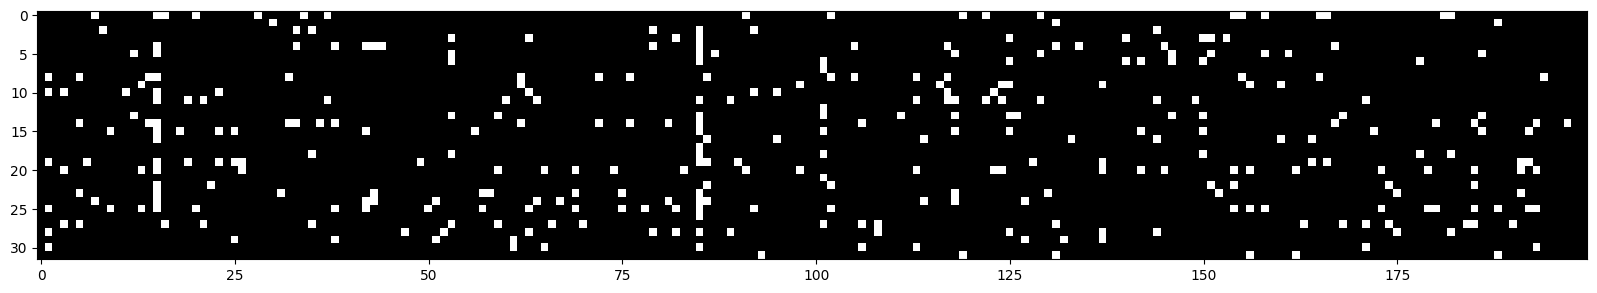

In [119]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest') #aboslute value of h, how ofren it is in the flat region(-1, 1)
# all tanh neurons backward gradients are destroyed, dead neuron of complete white

(array([518., 259., 223., 200., 148., 151., 135., 131., 155., 118., 106.,
        100., 149., 137., 143., 148., 135., 162., 208., 157., 146., 133.,
        139., 103., 111., 116., 116., 138., 130., 136., 133., 137., 173.,
        178., 214., 268., 546.]),
 array([-0.99998349, -0.94593051, -0.89187754, -0.83782456, -0.78377158,
        -0.72971861, -0.67566563, -0.62161266, -0.56755968, -0.5135067 ,
        -0.45945373, -0.40540075, -0.35134777, -0.2972948 , -0.24324182,
        -0.18918884, -0.13513587, -0.08108289, -0.02702992,  0.02702306,
         0.08107604,  0.13512901,  0.18918199,  0.24323497,  0.29728794,
         0.35134092,  0.4053939 ,  0.45944687,  0.51349985,  0.56755282,
         0.6216058 ,  0.67565878,  0.72971175,  0.78376473,  0.83781771,
         0.89187068,  0.94592366,  0.99997663]),
 <BarContainer object of 37 artists>)

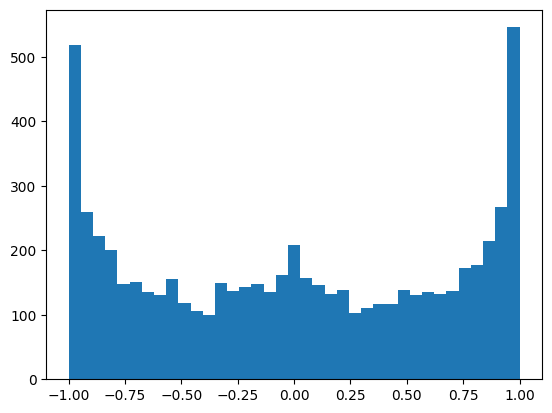

In [120]:

plt.hist(h.view(-1).tolist(), int(2*(len(h.view(-1).tolist()) ** (1. / 3))))

(array([  1.,   0.,   1.,   2.,   5.,  10.,  15.,  17.,  40.,  52.,  68.,
        131., 170., 220., 307., 403., 510., 592., 910., 685., 559., 426.,
        361., 258., 196., 138., 104.,  86.,  39.,  38.,  27.,   9.,   7.,
          6.,   2.,   3.,   2.]),
 array([-5.85318375, -5.54150081, -5.22981788, -4.91813495, -4.60645201,
        -4.29476908, -3.98308615, -3.67140321, -3.35972028, -3.04803735,
        -2.73635442, -2.42467148, -2.11298855, -1.80130562, -1.48962268,
        -1.17793975, -0.86625682, -0.55457388, -0.24289095,  0.06879198,
         0.38047492,  0.69215785,  1.00384078,  1.31552371,  1.62720665,
         1.93888958,  2.25057251,  2.56225545,  2.87393838,  3.18562131,
         3.49730425,  3.80898718,  4.12067011,  4.43235305,  4.74403598,
         5.05571891,  5.36740184,  5.67908478]),
 <BarContainer object of 37 artists>)

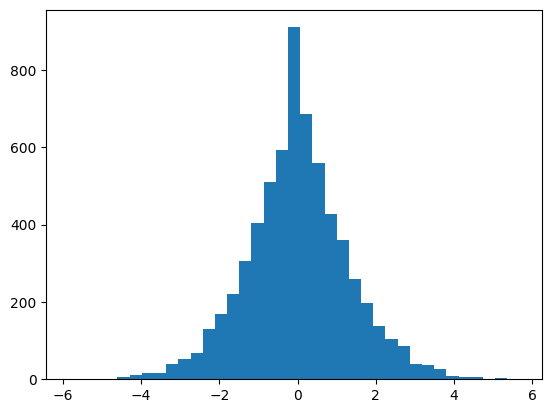

In [121]:
plt.hist(hpreact.view(-1).tolist(), int(2*(len(hpreact.view(-1).tolist()) ** (1. / 3))))

In [126]:
# calibrate batch norm at end of training cycles

with torch.no_grad():
    # pass the training through the set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    print(bnstd_running.shape)
    print(bnstd.shape)

torch.Size([1, 200])
torch.Size([1, 200])


In [127]:
@torch.no_grad() # disables grad tracking, no need to maintain the graph
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x] #[embdn, block_size, ]
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 
    # hpreact = bngain * (hpreact - hpreact.mean(1, keepdim=True)) / hpreact.std(1, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.074587106704712
val 2.1068625450134277


In [130]:
# sample from the model
g = torch.Generator().manual_seed(21476891001)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor(context)] #(1, block_size, n_embd)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break;
    print(''.join(itos[i] for i in out))

emyna.
onnit.
gina.
yulaniel.
muzsinn.
war.
alle.
nicorram.
nae.
coina.
sta.
kafarre.
inda.
tayrah.
ash.
iya.
ise.
anji.
nusheke.
jaeriya.
